<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL-Tutorials/blob/master/2-Advance/FinRL_Ensemble_StockTrading_ICAIF_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading Using Ensemble Strategy

Tutorials to use OpenAI DRL to trade multiple stocks using ensemble strategy in one Jupyter Notebook | Presented at ICAIF 2020

* This notebook is the reimplementation of our paper: Deep Reinforcement Learning for Automated Stock Trading: An Ensemble Strategy, using FinRL.
* Check out medium blog for detailed explanations: https://medium.com/@ai4finance/deep-reinforcement-learning-for-automated-stock-trading-f1dad0126a02
* Please report any issues to our Github: https://github.com/AI4Finance-LLC/FinRL-Library/issues
* **Pytorch Version** 



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)             

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [ ]:
!pip install stable_baselines3
!pip install yfinance
!pip install tushare
!pip install exchange_calendars
!pip install wrds
!pip install alpaca_trade_api
!pip install stockstats
!pip install pyfolio

In [ ]:
# ## install finrl library
!pip install wrds
!pip install swig
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading_disharpe import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

/Users/hanlinwang/Documents/anaconda/anaconda3/envs/rl_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/hanlinwang/Documents/anaconda/anaconda3/envs/rl_env/lib/python3.8/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


<a id='1.4'></a>
## 2.4. Create Folders

In [3]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [ ]:
print(DOW_30_TICKER)

In [ ]:
df = pd.read_csv('merged_df.csv')
df

In [4]:
TRAIN_START_DATE = '2012-10-10'
TRAIN_END_DATE = '2021-02-28'
TEST_START_DATE = '2021-03-01'
TEST_END_DATE = '2023-02-28'

In [5]:
import tushare as ts
ts.set_token('6314756019e50a6672690e5a78b2dbf7cfcd27c6f6a6b48a8cf76dae')
pro = ts.pro_api()

In [6]:
#选择上证50指数的成分股
df_index = pro.index_weight(index_code='000016.sh', start_date='20121010', end_date='20220228')
# df_index.to_csv('SSE_50_index_weight.csv',index=0)

In [7]:
#选择某个时间点的上证50指数成分股作为参考跟踪股票池
select_date = '20200228' #自定义的时间点为每个月的月末
df_select = df_index[df_index['trade_date']==select_date]
sort_SSEindex = df_select['con_code'].unique()
print(sort_SSEindex,len(sort_SSEindex))

['603993.SH' '603259.SH' '601989.SH' '601988.SH' '601939.SH' '601888.SH'
 '601857.SH' '601818.SH' '601766.SH' '601688.SH' '601668.SH' '601628.SH'
 '601601.SH' '601398.SH' '601390.SH' '601336.SH' '601328.SH' '601319.SH'
 '601318.SH' '601288.SH' '601236.SH' '601211.SH' '601186.SH' '601166.SH'
 '601138.SH' '601111.SH' '601088.SH' '601066.SH' '601012.SH' '600887.SH'
 '600837.SH' '600703.SH' '600690.SH' '600585.SH' '600547.SH' '600519.SH'
 '600340.SH' '600309.SH' '600276.SH' '600196.SH' '600104.SH' '600050.SH'
 '600048.SH' '600036.SH' '600031.SH' '600030.SH' '600028.SH' '600016.SH'
 '600009.SH' '600000.SH'] 50


In [8]:
#随机选择成分股中的k只股票
import random 
k = 20
selected_tics = random.sample(list(sort_SSEindex),k)
print(selected_tics)

['601236.SH', '601888.SH', '601288.SH', '600703.SH', '601988.SH', '600837.SH', '600340.SH', '601211.SH', '600519.SH', '601328.SH', '601857.SH', '600196.SH', '601818.SH', '603993.SH', '600031.SH', '600009.SH', '601939.SH', '600309.SH', '601398.SH', '601066.SH']


In [17]:
#Download随机选择的k只股票数据
df_ts =pd.DataFrame()
for c in selected_tics:
    temp=pro.daily(ts_code=c,start_date='20121010',end_date='20230228')
    df_ts=pd.concat([df_ts,temp])
# df_ts = df_ts.sort_values(['ts_code','trade_date'],ascending=True).reset_index(drop=True)
print(df_ts)

        ts_code trade_date   open   high    low  close  pre_close  change  \
0     601236.SH   20230228   8.50   8.56   8.45   8.56       8.47    0.09   
1     601236.SH   20230227   8.55   8.56   8.43   8.47       8.60   -0.13   
2     601236.SH   20230224   8.78   8.80   8.54   8.60       8.78   -0.18   
3     601236.SH   20230223   8.66   8.88   8.66   8.78       8.67    0.11   
4     601236.SH   20230222   8.67   8.79   8.62   8.67       8.76   -0.09   
...         ...        ...    ...    ...    ...    ...        ...     ...   
1135  601066.SH   20180626  11.42  11.42  11.42  11.42      10.38    1.04   
1136  601066.SH   20180625  10.38  10.38  10.38  10.38       9.44    0.94   
1137  601066.SH   20180622   9.44   9.44   9.44   9.44       8.58    0.86   
1138  601066.SH   20180621   8.58   8.58   8.58   8.58       7.80    0.78   
1139  601066.SH   20180620   6.50   7.80   6.50   7.80       5.42    2.38   

      pct_chg        vol      amount  
0      1.0626  148636.62  126445.623

In [18]:
# 筛选exchange_calender中每个交易节点缺失(激进)
def processed_date(df,selected_tics,k):
    date_unique = list(df['trade_date'].unique())
    date_sum = len(date_unique)
    count = 0
    processe_df =[]
    processed_df = pd.DataFrame()
    for date in date_unique:
        temp_df = df[df['trade_date'] == date]
        if len(temp_df) == k:
            processe_df.append(temp_df)
        else :
            date_unique.remove(date)
        processed_df = pd.concat(processe_df,ignore_index = True)       
    processed_df = processed_df.sort_values('trade_date',ascending=True).reset_index()
    processed_df = processed_df.drop('index',axis=1)
    processed_df = processed_df.sort_values(['ts_code','trade_date'],ascending=True).reset_index(drop=True)
    return processed_df,date_unique
        

In [19]:
processed_df,date_unique = processed_date(df_ts,selected_tics,k)
print(processed_df) 

         ts_code trade_date   open   high    low  close  pre_close  change  \
0      600009.SH   20190705  80.00  82.10  79.45  81.40      79.75    1.65   
1      600009.SH   20190708  80.73  81.00  79.00  79.79      81.40   -1.61   
2      600009.SH   20190709  79.62  81.11  79.52  80.39      79.79    0.60   
3      600009.SH   20190710  80.55  81.90  80.10  81.40      80.39    1.01   
4      600009.SH   20190711  81.78  81.95  80.06  80.18      81.40   -1.22   
...          ...        ...    ...    ...    ...    ...        ...     ...   
17035  603993.SH   20230222   6.13   6.21   6.07   6.14       6.18   -0.04   
17036  603993.SH   20230223   6.17   6.23   6.07   6.17       6.14    0.03   
17037  603993.SH   20230224   6.11   6.13   5.95   5.99       6.17   -0.18   
17038  603993.SH   20230227   5.91   5.99   5.81   5.87       5.99   -0.12   
17039  603993.SH   20230228   5.91   5.95   5.83   5.90       5.87    0.03   

       pct_chg         vol       amount  
0       2.0690   1564

In [20]:
def process_fillna(df,selected_tics,k):
    merge_df = []
    for tic in selected_tics:
        temp_df = df[df['ts_code']==tic]
        temp_df = temp_df.reset_index().sort_values('trade_date',ascending=True)
        temp_df = temp_df.fillna({
            'amount' : 0,
            'vol': 0,
            'pct_chg': 0,
            'change':0,
            'ts_code': tic
        })
        for i in range(len(temp_df)):
            if pd.isna(temp_df.loc[i,'close']):
                j = i +1
                while pd.isna(temp_df.loc[j,'close']):
                    j = j + 1
                if j < len(temp_df) :
                    temp_df.loc[i,['close','open','high','low','pre_close']] = temp_df.loc[j,'close']
        merge_df.append(temp_df)
    merged_df = pd.concat(merge_df,ignore_index = True)
    return merged_df

In [21]:
merged_df = process_fillna(processed_df,selected_tics,k)
merged_df = merged_df.drop('index',axis=1)
merged_df

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,601236.SH,20190705,4.15,4.98,4.15,4.98,3.46,1.52,43.9306,2634.71,1310.841
1,601236.SH,20190708,5.48,5.48,5.48,5.48,4.98,0.50,10.0402,1839.56,1008.079
2,601236.SH,20190709,6.03,6.03,6.03,6.03,5.48,0.55,10.0365,2143.79,1292.705
3,601236.SH,20190710,6.63,6.63,6.63,6.63,6.03,0.60,9.9502,5273.42,3496.277
4,601236.SH,20190711,7.29,7.29,7.29,7.29,6.63,0.66,9.9548,10041.54,7320.283
...,...,...,...,...,...,...,...,...,...,...,...
17035,601066.SH,20230222,26.94,27.30,26.59,26.78,27.10,-0.32,-1.1808,201843.24,543373.383
17036,601066.SH,20230223,26.79,27.38,26.79,26.97,26.78,0.19,0.7095,211560.66,573233.966
17037,601066.SH,20230224,26.95,26.95,26.46,26.51,26.97,-0.46,-1.7056,148496.45,395452.799
17038,601066.SH,20230227,26.31,26.55,26.01,26.28,26.51,-0.23,-0.8676,126334.77,332522.232


In [22]:
# merged_df = merged_df.drop('volume',axis=1)
merged_df = merged_df.rename(columns={'trade_date':'date','ts_code':'tic','vol':'volume'})
merged_df = merged_df[['tic','date','open','high','low','close','pre_close','change','pct_chg','volume','amount']]
# merged_df = merged_df.drop('index',axis=1)
merged_df = merged_df.sort_values(['tic','date'],ascending=True).reset_index(drop=True)
print(merged_df)

             tic      date   open   high    low  close  pre_close  change  \
0      600009.SH  20190705  80.00  82.10  79.45  81.40      79.75    1.65   
1      600009.SH  20190708  80.73  81.00  79.00  79.79      81.40   -1.61   
2      600009.SH  20190709  79.62  81.11  79.52  80.39      79.79    0.60   
3      600009.SH  20190710  80.55  81.90  80.10  81.40      80.39    1.01   
4      600009.SH  20190711  81.78  81.95  80.06  80.18      81.40   -1.22   
...          ...       ...    ...    ...    ...    ...        ...     ...   
17035  603993.SH  20230222   6.13   6.21   6.07   6.14       6.18   -0.04   
17036  603993.SH  20230223   6.17   6.23   6.07   6.17       6.14    0.03   
17037  603993.SH  20230224   6.11   6.13   5.95   5.99       6.17   -0.18   
17038  603993.SH  20230227   5.91   5.99   5.81   5.87       5.99   -0.12   
17039  603993.SH  20230228   5.91   5.95   5.83   5.90       5.87    0.03   

       pct_chg      volume       amount  
0       2.0690   156494.97  12597

In [ ]:
merged_df[merged_df['date']=='2020']

In [ ]:
df.tail()

In [ ]:
df.shape

In [ ]:
df.sort_values(['date','tic']).head()

In [ ]:
len(df.tic.unique())

In [ ]:
df.tic.value_counts()

# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [23]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = INDICATORS,
                    use_vix=False,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.add_technical_indicator(merged_df)
processed = fe.add_turbulence(processed)
processed = processed.fillna(method="ffill").fillna(method="bfill")

In [24]:
import datetime
processed['date'] = pd.to_datetime(processed['date'],format='%Y%m%d')
processed

,tic,date,open,high,low,close,pre_close,change,pct_chg,volume,amount,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
0,600009.SH,2019-07-05,80.00,82.10,79.45,81.40,79.75,1.65,2.0690,156494.97,1259765.768,0.000000,82.871884,78.318116,0.000000,-66.666667,100.000000,81.400000,81.400000,0.000000
1,600031.SH,2019-07-05,12.89,12.94,12.77,12.87,12.86,0.01,0.0778,472956.33,607638.106,0.000000,82.871884,78.318116,0.000000,-66.666667,100.000000,12.870000,12.870000,0.000000
2,600196.SH,2019-07-05,26.68,26.94,26.58,26.81,26.51,0.30,1.1316,130610.00,350094.412,0.000000,82.871884,78.318116,0.000000,-66.666667,100.000000,26.810000,26.810000,0.000000
3,600309.SH,2019-07-05,43.06,43.70,42.68,43.48,42.86,0.62,1.4466,135936.40,589678.234,0.000000,82.871884,78.318116,0.000000,-66.666667,100.000000,43.480000,43.480000,0.000000
4,600340.SH,2019-07-05,33.29,33.29,32.35,32.72,33.39,-0.67,-2.0066,127041.89,416496.783,0.000000,82.871884,78.318116,0.000000,-66.666667,100.000000,32.720000,32.720000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17035,601857.SH,2023-02-28,5.22,5.23,5.19,5.23,5.21,0.02,0.3839,780918.59,407149.028,0.034798,5.268681,5.107319,55.051080,74.675995,37.378042,5.160333,5.118167,3.985424
17036,601888.SH,2023-02-28,198.30,199.29,194.91,197.58,197.31,0.27,0.1368,88489.10,1739191.785,-4.807180,214.190900,194.433100,44.255329,-95.615136,30.966717,211.779333,213.524500,3.985424
17037,601939.SH,2023-02-28,5.60,5.64,5.59,5.64,5.59,0.05,0.8945,349951.06,196505.114,0.003892,5.644186,5.558814,53.841443,34.768020,24.251462,5.608000,5.598500,3.985424
17038,601988.SH,2023-02-28,3.22,3.23,3.21,3.23,3.21,0.02,0.6231,853848.32,274898.437,0.009230,3.244136,3.186864,56.543761,30.502269,23.055244,3.215000,3.183500,3.985424


In [25]:
list_ticker = processed["tic"].unique().tolist()
# list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
# combination = list(itertools.product(list_date,list_ticker))

# processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
# processed_full = processed_full[processed_full['date'].isin(processed['date'])]
# processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed

<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

In [26]:
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 20, State Space: 201


In [27]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001, 
    "sell_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4,
    "print_verbosity":5
    
}

<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

* In this notebook, we are training and validating 3 agents (A2C, PPO, DDPG) using Rolling-window Ensemble Method ([reference code](https://github.com/AI4Finance-LLC/Deep-Reinforcement-Learning-for-Automated-Stock-Trading-Ensemble-Strategy-ICAIF-2020/blob/80415db8fa7b2179df6bd7e81ce4fe8dbf913806/model/models.py#L92))

In [28]:
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)

ensemble_agent = DRLEnsembleAgent(df=processed,
                 train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                 val_test_period=(TEST_START_DATE,TEST_END_DATE),
                 rebalance_window=rebalance_window, 
                 validation_window=validation_window, 
                 **env_kwargs)



In [30]:
TEST_END_DATE

'2023-02-28'

In [31]:
SAC_model_kwargs = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
                }

PPO_model_kwargs = {
    "ent_coef":0.01,
    "n_steps": 2048,
    "learning_rate": 0.00025,
    "batch_size": 128
                    }

TD3_model_kwargs = {
    "batch_size": 100, 
    "buffer_size": 1000000, 
    "learning_rate": 0.001
                }

timesteps_dict = {'sac' : 10000, 
                 'ppo' : 10000, 
                 'td3' : 10000
                 }

In [32]:
import torch
device = torch.device("mps")

In [33]:
df_summary = ensemble_agent.run_ensemble_strategy_com(SAC_model_kwargs,
                                                 PPO_model_kwargs,
                                                 TD3_model_kwargs,
                                                 timesteps_dict)

============Start Ensemble Strategy============
turbulence_threshold:  79.02797945050015
======Model training from:  2010-10-10 to  2021-03-02T00:00:00.000000000
======SAC Training========
{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device
Logging to tensorboard_log/sac/sac_126_7
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 152       |
|    time_elapsed    | 10        |
|    total_timesteps | 1564      |
| train/             |           |
|    actor_loss      | 57.4      |
|    critic_loss     | 2.51e+03  |
|    ent_coef        | 0.111     |
|    ent_coef_loss   | 263       |
|    learning_rate   | 0.0001    |
|    n_updates       | 1463      |
|    reward          | 10.747904 |
----------------------------------
day: 390, episode: 5
begin_total_asset: 1000000.00
end_total_asset: 1723971.30
total_reward: 723971.30
total_cos

day: 390, episode: 50
begin_total_asset: 1000000.00
end_total_asset: 1726811.95
total_reward: 726811.95
total_cost: 36514.86
total_trades: 7398
Sharpe: 1.451
-----------------------------------------
| time/                   |             |
|    fps                  | 1127        |
|    iterations           | 5           |
|    time_elapsed         | 9           |
|    total_timesteps      | 10240       |
| train/                  |             |
|    approx_kl            | 0.014507908 |
|    clip_fraction        | 0.145       |
|    clip_range           | 0.2         |
|    entropy_loss         | -28.4       |
|    explained_variance   | -0.00541    |
|    learning_rate        | 0.00025     |
|    loss                 | 9.87        |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.0169     |
|    reward               | 1.4097894   |
|    std                  | 1           |
|    value_loss           | 22.6        |
-----------------------------------------
==

day: 453, episode: 20
begin_total_asset: 1000000.00
end_total_asset: 1987090.71
total_reward: 987090.71
total_cost: 2787.70
total_trades: 5241
Sharpe: 1.313
----------------------------------
| time/              |           |
|    episodes        | 20        |
|    fps             | 147       |
|    time_elapsed    | 61        |
|    total_timesteps | 9080      |
| train/             |           |
|    actor_loss      | 351       |
|    critic_loss     | 295       |
|    ent_coef        | 0.16      |
|    ent_coef_loss   | -48.2     |
|    learning_rate   | 0.0001    |
|    n_updates       | 8979      |
|    reward          | -1.687742 |
----------------------------------
======SAC Validation from:  2021-06-03T00:00:00.000000000 to  2021-10-12T00:00:00.000000000
SAC Sharpe Ratio:  0.14710786196446984
======PPO Training========
{'ent_coef': 0.01, 'n_steps': 2048, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Logging to tensorboard_log/ppo/ppo_189_4
day: 453, episode: 25

day: 453, episode: 65
begin_total_asset: 1000000.00
end_total_asset: 2458849.83
total_reward: 1458849.83
total_cost: 1627.48
total_trades: 4638
Sharpe: 1.518
----------------------------------
| time/              |           |
|    episodes        | 20        |
|    fps             | 207       |
|    time_elapsed    | 43        |
|    total_timesteps | 9080      |
| train/             |           |
|    actor_loss      | -89.6     |
|    critic_loss     | 436       |
|    learning_rate   | 0.001     |
|    n_updates       | 8626      |
|    reward          | -4.339012 |
----------------------------------
======TD3 Validation from:  2021-06-03T00:00:00.000000000 to  2021-10-12T00:00:00.000000000
======Best Model Retraining from:  2010-10-10 to  2021-10-12T00:00:00.000000000
======Trading from:  2021-10-12T00:00:00.000000000 to  2022-01-10T00:00:00.000000000
turbulence_threshold:  79.02797945050015
======Model training from:  2010-10-10 to  2021-10-12T00:00:00.000000000
======SAC Traini

======PPO Validation from:  2021-10-12T00:00:00.000000000 to  2022-01-10T00:00:00.000000000
PPO Sharpe Ratio:  0.03817332825902005
======TD3 Training========
{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device
Logging to tensorboard_log/td3/td3_252_2
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 230      |
|    time_elapsed    | 8        |
|    total_timesteps | 2068     |
| train/             |          |
|    actor_loss      | 328      |
|    critic_loss     | 1.06e+04 |
|    learning_rate   | 0.001    |
|    n_updates       | 1551     |
|    reward          | 1.991026 |
---------------------------------
day: 516, episode: 45
begin_total_asset: 1000000.00
end_total_asset: 1580045.74
total_reward: 580045.74
total_cost: 1047.55
total_trades: 5192
Sharpe: 0.856
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps       

-----------------------------------------
| time/                   |             |
|    fps                  | 889         |
|    iterations           | 3           |
|    time_elapsed         | 6           |
|    total_timesteps      | 6144        |
| train/                  |             |
|    approx_kl            | 0.009376157 |
|    clip_fraction        | 0.114       |
|    clip_range           | 0.2         |
|    entropy_loss         | -28.5       |
|    explained_variance   | 0.0027      |
|    learning_rate        | 0.00025     |
|    loss                 | 11.2        |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.0131     |
|    reward               | 0.3876952   |
|    std                  | 1           |
|    value_loss           | 22.1        |
-----------------------------------------
day: 579, episode: 30
begin_total_asset: 1000000.00
end_total_asset: 1194439.66
total_reward: 194439.66
total_cost: 64075.33
total_trades: 11184
Sharpe: 0.471
-

day: 642, episode: 15
begin_total_asset: 1000000.00
end_total_asset: 1144513.08
total_reward: 144513.08
total_cost: 31564.90
total_trades: 10160
Sharpe: 0.328
======SAC Validation from:  2022-04-20T00:00:00.000000000 to  2022-07-22T00:00:00.000000000
SAC Sharpe Ratio:  0.294949412734109
======PPO Training========
{'ent_coef': 0.01, 'n_steps': 2048, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Logging to tensorboard_log/ppo/ppo_378_1
-----------------------------------
| time/              |            |
|    fps             | 927        |
|    iterations      | 1          |
|    time_elapsed    | 2          |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | 0.72547334 |
-----------------------------------
day: 642, episode: 20
begin_total_asset: 1000000.00
end_total_asset: 1042101.02
total_reward: 42101.02
total_cost: 73011.08
total_trades: 12291
Sharpe: 0.183
----------------------------------------
| time/                

day: 705, episode: 5
begin_total_asset: 1000000.00
end_total_asset: 1410837.25
total_reward: 410837.25
total_cost: 1400.35
total_trades: 7103
Sharpe: 0.514
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 138       |
|    time_elapsed    | 40        |
|    total_timesteps | 5648      |
| train/             |           |
|    actor_loss      | 2.43e+03  |
|    critic_loss     | 5.29e+03  |
|    ent_coef        | 0.169     |
|    ent_coef_loss   | 334       |
|    learning_rate   | 0.0001    |
|    n_updates       | 5547      |
|    reward          | -1.709057 |
----------------------------------
day: 705, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 1168770.11
total_reward: 168770.11
total_cost: 1660.12
total_trades: 7182
Sharpe: 0.340
----------------------------------
| time/              |           |
|    episodes        | 12        |
|    fps             | 137       |
|    time_elapsed    |

Ensemble Strategy took:  13.759695446491241  minutes


In [34]:
df_summary

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe
0,126,2021-03-02,2021-06-03,TD3,-0.072005,0.090402,0.170161
1,189,2021-06-03,2021-10-12,SAC,0.147108,-0.149662,0.03356
2,252,2021-10-12,2022-01-10,TD3,-0.277727,0.038173,0.051169
3,315,2022-01-10,2022-04-20,SAC,-0.091845,-0.306913,-0.10668
4,378,2022-04-20,2022-07-22,TD3,0.294949,0.336205,0.382721
5,441,2022-07-22,2022-10-27,SAC,-0.196851,-0.371058,-0.534492


<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [35]:
unique_trade_date = processed[(processed.date > TEST_START_DATE)&(processed.date <= TEST_END_DATE)].date.unique()

In [36]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = df_account_value.append(temp,ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  -0.08580689027046685


In [37]:
df_account_value

,account_value,date,daily_return,datadate
0,1.000000e+06,2021-06-03,NaN,2021-06-03
1,1.002244e+06,2021-06-04,0.002244,2021-06-04
2,1.001966e+06,2021-06-07,-0.000277,2021-06-07
3,9.935401e+05,2021-06-08,-0.008409,2021-06-08
4,9.947387e+05,2021-06-09,0.001206,2021-06-09
...,...,...,...,...
373,9.068946e+05,2023-01-18,-0.003330,2023-01-18
374,9.093270e+05,2023-01-19,0.002682,2023-01-19
375,9.044313e+05,2023-01-20,-0.005384,2023-01-20
376,9.216236e+05,2023-01-30,0.019009,2023-01-30


<Axes: >

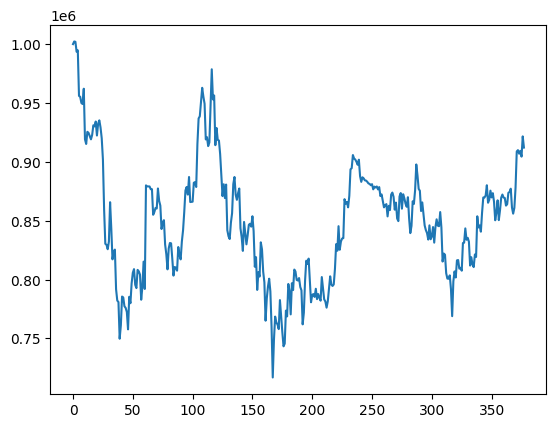

In [38]:
%matplotlib inline
df_account_value.account_value.plot()

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [39]:
print("==============Get Backtest Results===========")
#now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
#perf_stats_all.to_csv("./"+RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return         -0.059466
Cumulative returns    -0.087859
Annual volatility      0.276020
Sharpe ratio          -0.085807
Calmar ratio          -0.208805
Stability              0.005619
Max drawdown          -0.284791
Omega ratio            0.984785
Sortino ratio         -0.126291
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.023003
Daily value at risk   -0.034869
dtype: float64


In [40]:
#获取随机选择的tic在select_date的权重并修正
def get_selected_index_weight(df_index,select_date,selected_tics):
    df = df_index[df_index['trade_date'] == select_date]
    select_df = df[df['con_code'].isin(selected_tics)]
    select_df = select_df.drop('index_code',axis=1).rename(columns={'con_code':'tic','trade_date':'date'})
    select_df = select_df.reset_index()
    weight_sum = select_df['weight'].sum()
#     print(select_df)
    for i in range(len(select_df)):
        select_df.loc[i,'weight'] = (select_df.loc[i,'weight'] / weight_sum)*100
    return select_df.loc[:,['tic','date','weight']]

baseline_weight =get_selected_index_weight(df_index,select_date,selected_tics)
baseline_weight = baseline_weight.sort_values(['tic'],ascending=True).reset_index(drop=True)
print(baseline_weight)

          tic      date     weight
0   600009.SH  20200228   3.473945
1   600031.SH  20200228   5.637596
2   600196.SH  20200228   1.482782
3   600309.SH  20200228   4.051928
4   600340.SH  20200228   1.561460
5   600519.SH  20200228  29.141197
6   600703.SH  20200228   3.310537
7   600837.SH  20200228   6.309387
8   601066.SH  20200228   0.789808
9   601211.SH  20200228   4.206258
10  601236.SH  20200228   0.472069
11  601288.SH  20200228   7.168795
12  601328.SH  20200228   7.837560
13  601398.SH  20200228   6.273074
14  601818.SH  20200228   3.301459
15  601857.SH  20200228   2.702294
16  601888.SH  20200228   4.203232
17  601939.SH  20200228   2.393633
18  601988.SH  20200228   4.106397
19  603993.SH  20200228   1.576590


In [47]:
#计算所选股票的buy & hold策略
def calculate_selected_baseline(df,full_date_range,selected_tics):
    df = df.sort_values(['tic','date'],ascending=True).reset_index(drop=True)
    baseline = pd.DataFrame({'date':full_date_range['date']})
    for i in range(len(full_date_range)):
        temp_date = full_date_range.loc[i,'date']
        temp_df = df[df['date'] == temp_date].sort_values('tic',ascending=True)
        close = list(temp_df['close'])
        weight = list(baseline_weight['weight'])
        baseline.loc[i,'account_value'] = sum(np.array(close) * np.array(weight)) #注意权重和收盘价对应的股票顺序
    baseline['date'] = pd.to_datetime(baseline['date'])
#     baseline.set_index("date", inplace=True, drop=True)
#     baseline.index = baseline.index.tz_localize("UTC")
    return baseline
# full_date_range = get_trading_days(exchange='SSE',start_date='20210301', end_date='20230227')
# full_date_range = full_date_range.sort_values('trade_date',ascending=True).reset_index(drop=True)
full_date_range1 = pd.DataFrame({'date':df_account_value['date'].unique()}).reset_index(drop=True)
baseline_sse = calculate_selected_baseline(processed,full_date_range1,selected_tics)
baseline_sse

,date,account_value
0,2021-06-03,67472.696665
1,2021-06-04,68300.562731
2,2021-06-07,68851.120922
3,2021-06-08,66515.558252
4,2021-06-09,66753.746384
...,...,...
373,2023-01-18,57235.261787
374,2023-01-19,56875.717818
375,2023-01-20,56281.132603
376,2023-01-30,57048.146372


In [ ]:
merged_df

In [48]:
#baseline stats
print("==============Get Baseline Stats===========")
# baseline_df = get_baseline(
#         ticker="^DJI", 
#         start = df_account_value.loc[0,'date'],
#         end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_sse, value_col_name = 'account_value')

==============Get Baseline Stats===========
Annual return         -0.119075
Cumulative returns    -0.173185
Annual volatility      0.325736
Sharpe ratio          -0.228636
Calmar ratio          -0.294119
Stability              0.107979
Max drawdown          -0.404853
Omega ratio            0.960278
Sortino ratio         -0.333243
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.984050
Daily value at risk   -0.041334
dtype: float64


<a id='6.2'></a>
## 7.2 BackTestPlot

In [49]:
import pyfolio
from copy import deepcopy
def backtest_plot_com(
    account_value,
    baseline,
    baseline_start=TRADE_START_DATE,
    baseline_end=TRADE_END_DATE,
    value_col_name="account_value",
):
    df = deepcopy(account_value)
    df["date"] = pd.to_datetime(df["date"])
    test_returns = get_daily_return(df, value_col_name=value_col_name)
#     pro = ts.pro_api()
#     baseline_df = pro.index_daily(ts_code='000016.sh',start_date = '20200301',end_date='20230227')
#     baseline_df = baseline_df.rename(columns={'trade_date':'date'})
#     baseline_df = baseline_df.sort_values('date',ascending=True)
    baseline_returns = get_daily_return(baseline, value_col_name=value_col_name)
    with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(
            returns=test_returns, benchmark_rets=baseline_returns, set_context=False
        )

==============Compare to SSE50===========


Start date,2021-06-03
End date,2023-01-31
Total months,18
,Backtest
Annual return,-5.947%
Cumulative returns,-8.786%
Annual volatility,27.602%
Sharpe ratio,-0.09
Calmar ratio,-0.21
Stability,0.01
Max drawdown,-28.479%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,28.48,2021-06-04,2022-03-15,NaT,NaN
1,NaN,NaT,NaT,NaT,NaN
2,NaN,NaT,NaT,NaT,NaN
3,NaN,NaT,NaT,NaT,NaN
4,NaN,NaT,NaT,NaT,NaN


ConversionError: Failed to convert value(s) to axis units: (NaT, Timestamp('2023-01-31 00:00:00+0000', tz='UTC'))

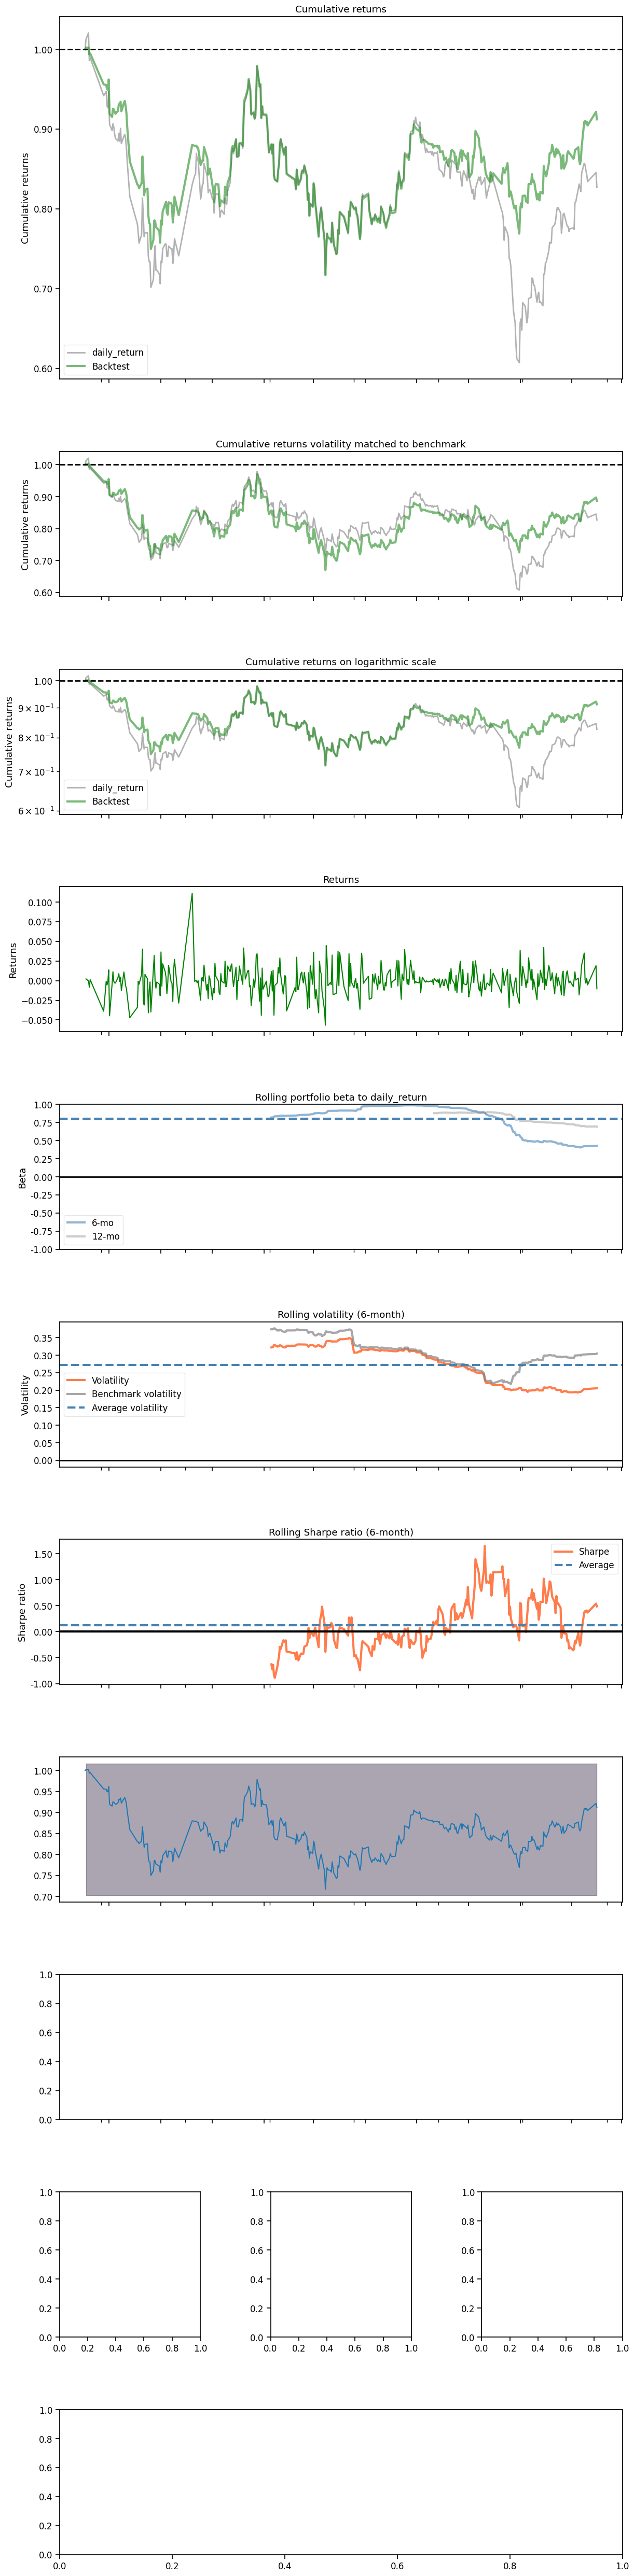

In [50]:
print("==============Compare to SSE50===========")
# from finrl.plot import backtest_plot_com
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot_com(account_value = df_account_value, 
                  baseline = baseline_sse,
                  baseline_start = df_account_value.loc[len(df_account_value)-1,'date'],
                  baseline_end = df_account_value.loc[0,'date']
                     )